# Initialisation

In [115]:
# Install lifelines library
#!pip install lifelines

In [116]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import *
from lifelines.statistics import logrank_test
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

## User defined functions

In [117]:
# Function to generate synthetic examples using bootstrapping with replacement
def bootstrap_samples(df, n_samples):
    synthetic_samples = []
    for _ in range(n_samples):
        bootstrap_sample = df.sample(n=len(df), replace=True)
        synthetic_samples.append(bootstrap_sample)
    return pd.concat(synthetic_samples)

# Load data

In [118]:
# Define data folder
data_folder = "../HOLM/SDS RWE Data Challenge Dataset/"

In [119]:
# Read in files
clin = pd.read_csv(data_folder  + "clinical_data.csv")
demo = pd.read_csv(data_folder  + "demographics.csv")

# Clean data

## Clinical data

In [120]:
# Print head
clin.head()

,id,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,medical_history_ren,medical_history_tum,medical_history_anx,medical_history_mood,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv
0,1d21f2be18683991eb93d182d6b2d220,1/1/11,11/1/11,0,1.0,0,0,0.0,0,0,...,0,0,0,1,1,71.3,161,2,2,2
1,62bdca0b95d97e99e1c712048fb9fd09,1/1/11,11/1/11,0,0.0,0,0,0.0,0,0,...,0,0,1,1,1,78.4,160,6,5,2
2,c85cf97bc6307ded0dd4fef8bad2fa09,2/1/11,13/1/11,0,0.0,0,0,0.0,0,0,...,1,1,1,1,0,72.0,151,5,5,4
3,e0397dd72caf4552c5babebd3d61736c,2/1/11,14/1/11,0,1.0,No,0,0.0,1,1,...,1,1,1,1,1,64.4,152,3,5,5
4,94ade3cd5f66f4584902554dff170a29,8/1/11,16/1/11,0,0.0,No,0,0.0,1,1,...,0,1,0,1,0,55.6,160,3,4,5


In [121]:
# Print shape
clin.shape

(3400, 26)

In [122]:
# Create a row id
clin["row_id"] = clin.index + 1

In [123]:
# Is there one row per patient?
clin["id"].nunique()

3000

There are multiple rows per patient, indicating multiple admissions per patient

In [124]:
# What is the maximum number of admissions per patient?
clin["id"].value_counts()

id
4e46fddfa404b306809c350aecbf0f6a    4
cf835526e33d00afa016ac898582038c    3
e3270f450ee164e596ca933a25bab61d    3
86cbe18dab50db6269046fc539915636    3
ea4f259bc46b6818f55b774abb7ac690    3
                                   ..
1674e89a8966b5c3a9d9abde436d8dc5    1
6d1b7ad0a96572595c814704f3943bc8    1
ae5530a383321f9a3986f333b44a85c4    1
abcaddd0aead7990bbd88526bc1670b5    1
a4c61deaa9ce86b4d2289eab6128b872    1
Name: count, Length: 3000, dtype: int64

In [125]:
# Clean dates
clin["date_of_admission"] = pd.to_datetime(clin["date_of_admission"],format="%d/%m/%y")
clin["date_of_discharge"] = pd.to_datetime(clin["date_of_discharge"],format="%d/%m/%y")

In [126]:
# Calculate BMI variable
clin["bmi"] = round((clin["weight"] / (clin["height"]/100)**2),2)

In [127]:
# Print head
clin.head()

,id,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,medical_history_ren,medical_history_tum,medical_history_anx,medical_history_mood,...,symptom_3,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,row_id,bmi
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,...,0,1,1,71.3,161,2,2,2,1,27.51
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,...,1,1,1,78.4,160,6,5,2,2,30.62
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,...,1,1,0,72.0,151,5,5,4,3,31.58
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,...,1,1,1,64.4,152,3,5,5,4,27.87
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,...,0,1,0,55.6,160,3,4,5,5,21.72


## Demographics

In [128]:
# Print head
demo.head()

,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


In [129]:
# Print shape
demo.shape

(3000, 5)

In [130]:
# Is there one row per patient?
demo["patient_id"].nunique()

3000

There is one row per patient

In [131]:
# Print gender values
demo["gender"].value_counts()

gender
Female    1396
Male      1333
m          170
f          101
Name: count, dtype: int64

In [132]:
# Clean gender column
replace_values = {
    "f" : "Female", 
    "m" : "Male"}                                                                                          
demo = demo.replace({"gender": replace_values}) 

In [133]:
# Print gender values
demo["gender"].value_counts()

gender
Male      1503
Female    1497
Name: count, dtype: int64

In [134]:
# Clean dates
demo["date_of_birth"] = pd.to_datetime(demo["date_of_birth"],format="%Y-%m-%y")

In [135]:
# Print head
demo.head()

,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,2014-05-01
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,2018-02-01
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,2003-07-01
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,2015-06-01
4,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singaporean,2012-12-01


In [136]:
# Print race values
demo["race"].value_counts()

race
Chinese    1608
Malay       629
chinese     307
Indian      195
Others      161
India       100
Name: count, dtype: int64

In [137]:
# Clean race column
replace_values = {
    "chinese" : "Chinese", 
    "India" : "Indian",
    "Others" : "Other"}                                                                                          
demo = demo.replace({"race": replace_values}) 

In [138]:
# Print race values
demo["race"].value_counts()

race
Chinese    1915
Malay       629
Indian      295
Other       161
Name: count, dtype: int64

In [139]:
# Print resident status values
demo["resident_status"].value_counts()

resident_status
Singaporean          1782
Singapore citizen     610
PR                    465
Foreigner             143
Name: count, dtype: int64

In [140]:
# Clean resident status column
replace_values = {
    "Singapore citizen" : "Singaporean"}                                                                                
demo = demo.replace({"resident_status": replace_values}) 

In [141]:
# Print resident status values
demo["resident_status"].value_counts()

resident_status
Singaporean    2392
PR              465
Foreigner       143
Name: count, dtype: int64

## Combine

In [142]:
# Left join demographics data to clinical data
clin = pd.merge(clin, demo, how="left", left_on="id", right_on="patient_id")
clin.drop(columns="patient_id",axis=1, inplace=True)

In [143]:
# Create age at admission variable
clin["age_at_admission"] = (clin["date_of_admission"].dt.year - clin["date_of_birth"].dt.year).astype(int)

In [144]:
# Identify first admission (index)
clin = clin.sort_values(by=["id","date_of_admission"], ascending=[True,True])
clin_fa = clin.drop_duplicates(subset="id",keep="first")
clin_fa.shape

(3000, 33)

In [145]:
# Remove first admissions from clin
clin_oa = clin[~clin["row_id"].isin(clin_fa["row_id"])].reset_index(drop=True)
clin_oa = clin_oa.sort_values(by=["id","date_of_admission"], ascending=[True,True])
clin_oa = clin_oa.drop_duplicates(subset="id",keep="first")
clin_oa["readmission"] = 1

In [146]:
# Join readmission variables to first admission
clin_oa.rename(columns={"date_of_admission" : "date_of_readmission"},inplace=True)
clin_fa = pd.merge(clin_fa, clin_oa[["id","readmission","date_of_readmission"]], how="left", on="id")
clin_fa["readmission"] = clin_fa["readmission"].fillna(0)

In [147]:
# Calculate time to readmission
clin_fa["time_to_readmission"] = (clin_fa["date_of_readmission"] - clin_fa["date_of_admission"]).dt.days

In [148]:
# Right censor data to the max discharge date
clin_fa_read = clin_fa[clin_fa["readmission"]==1].reset_index(drop=True)
clin_fa_none = clin_fa[clin_fa["readmission"]==0].reset_index(drop=True)
clin_fa_none["time_to_readmission"] = (clin["date_of_discharge"].max() - clin_fa["date_of_admission"]).dt.days
clin_fa = pd.concat([clin_fa_read,clin_fa_none])
del clin_fa_read, clin_fa_none

In [149]:
# Print head
clin_fa.head()

,id,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,medical_history_ren,medical_history_tum,medical_history_anx,medical_history_mood,...,row_id,bmi,gender,race,resident_status,date_of_birth,age_at_admission,readmission,date_of_readmission,time_to_readmission
0,012c5eb5397a72f8aeb64f942b60846d,2011-06-08,2011-06-23,0,0.0,0,0,0.0,1,0,...,302,33.92,Male,Malay,Singaporean,2024-03-01,-13,1.0,2015-11-17,1623.0
1,0284ec8aa1e6ced9ddaa7702b841248d,2014-02-26,2014-03-04,0,0.0,0,0,0.0,0,0,...,2123,24.81,Female,Indian,Singaporean,2011-10-01,3,1.0,2014-06-21,115.0
2,03d6bdbc614a5bdbeadf5b981a59c423,2011-02-01,2011-02-20,0,1.0,0,0,0.0,1,0,...,65,33.82,Female,Chinese,Singaporean,2014-02-01,-3,1.0,2015-06-04,1584.0
3,050df896aaa8cbad8fc1988bc1f79ebc,2015-01-18,2015-01-31,0,0.0,0,0,0.0,0,0,...,2745,30.15,Male,Chinese,PR,2025-12-01,-10,1.0,2015-10-13,268.0
4,0628639ffb53c8b38389a6e01897a6a5,2012-12-13,2012-12-24,0,0.0,0,0,0.0,0,1,...,1318,27.33,Female,Indian,Singaporean,2001-08-01,11,1.0,2014-07-17,581.0


In [150]:
# Print columns
clin_fa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 2620
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    3000 non-null   object        
 1   date_of_admission     3000 non-null   datetime64[ns]
 2   date_of_discharge     3000 non-null   datetime64[ns]
 3   medical_history_dia   3000 non-null   int64         
 4   medical_history_sud   2798 non-null   float64       
 5   medical_history_hbp   3000 non-null   object        
 6   medical_history_ren   3000 non-null   int64         
 7   medical_history_tum   2731 non-null   float64       
 8   medical_history_anx   3000 non-null   int64         
 9   medical_history_mood  3000 non-null   int64         
 10  trt_anx               3000 non-null   int64         
 11  trt_con               3000 non-null   int64         
 12  trt_adt               3000 non-null   int64         
 13  trt_ssr               3

# Analysis

In [151]:
# Create a treatment 1 group, i.e. the standard treatment of anti-depressants with or without therapy
trt1 = clin_fa[(clin_fa["trt_adt"]==1) & ((clin_fa["trt_the"]==1) | (clin_fa["trt_the"]==0)) & (clin_fa["trt_con"]==0) & (clin_fa["trt_ssr"]==0) & (clin_fa["trt_oth"]==0)].reset_index(drop=True)
trt1["group"] = "Trt 1"
trt1.shape

(113, 37)

In [152]:
# Create a treatment 2 group, i.e. the standard treatment of anti-depressants with or without therapy plus an adjunctvant medication
trt2 = clin_fa[(clin_fa["trt_adt"]==1) & ((clin_fa["trt_the"]==1) | (clin_fa["trt_the"]==0)) & ((clin_fa["trt_con"]==1) | (clin_fa["trt_ssr"]==1) | (clin_fa["trt_oth"]==1))].reset_index(drop=True)
trt2["group"] = "Trt 2"
trt2.shape

(2348, 37)

In [153]:
# Combine
expr = pd.concat([trt1,trt2])
expr.shape

(2461, 37)

## Demographics

### Age

In [156]:
# Print summary table
st = expr.groupby("group")["age_at_admission"].describe()
print(st)

        count      mean       std   min   25%  50%  75%   max
group                                                        
Trt 1   113.0 -2.362832  8.497964 -17.0 -10.0 -3.0  5.0  14.0
Trt 2  2348.0 -1.517888  8.163650 -17.0  -8.0 -1.0  5.0  14.0


### Gender

In [165]:
# Print summary table
st = expr.groupby("group")["gender"].value_counts()
print(st)

group  gender
Trt 1  Female      59
       Male        54
Trt 2  Male      1188
       Female    1160
Name: count, dtype: int64


In [167]:
# Print summary table
st = expr.groupby("group")["gender"].value_counts(normalize=True)
print(st)

group  gender
Trt 1  Female    0.522124
       Male      0.477876
Trt 2  Male      0.505963
       Female    0.494037
Name: proportion, dtype: float64


### Race

In [164]:
# Print summary table
st = expr.groupby("group")["race"].value_counts()
print(st)

group  race   
Trt 1  Chinese      78
       Malay        23
       Indian        8
       Other         4
Trt 2  Chinese    1501
       Malay       489
       Indian      239
       Other       119
Name: count, dtype: int64


In [168]:
# Print summary table
st = expr.groupby("group")["race"].value_counts(normalize=True)
print(st)

group  race   
Trt 1  Chinese    0.690265
       Malay      0.203540
       Indian     0.070796
       Other      0.035398
Trt 2  Chinese    0.639267
       Malay      0.208262
       Indian     0.101789
       Other      0.050681
Name: proportion, dtype: float64


### Resident status

In [169]:
# Print summary table
st = expr.groupby("group")["resident_status"].value_counts()
print(st)

group  resident_status
Trt 1  Singaporean          89
       PR                   20
       Foreigner             4
Trt 2  Singaporean        1878
       PR                  351
       Foreigner           119
Name: count, dtype: int64


In [170]:
# Print summary table
st = expr.groupby("group")["resident_status"].value_counts(normalize=True)
print(st)

group  resident_status
Trt 1  Singaporean        0.787611
       PR                 0.176991
       Foreigner          0.035398
Trt 2  Singaporean        0.799830
       PR                 0.149489
       Foreigner          0.050681
Name: proportion, dtype: float64


## Kaplan-Meier

### Raw data

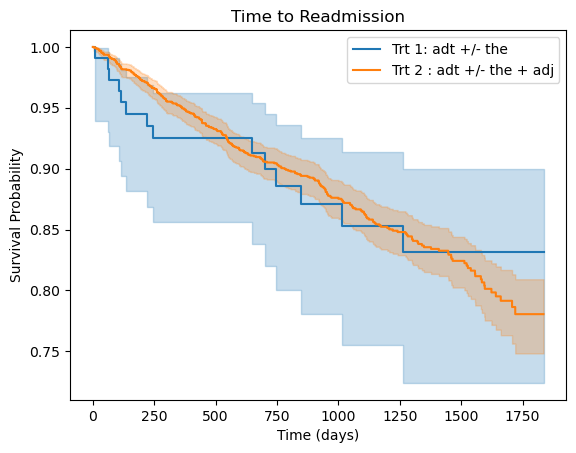

In [93]:
# Create a Kaplan-Meier plot
kmf = KaplanMeierFitter()
kmf.fit(trt1["time_to_readmission"], event_observed=trt1["readmission"], label='Trt 1: adt +/- the')
ax = kmf.plot()
kmf.fit(trt2["time_to_readmission"], event_observed=trt2["readmission"], label='Trt 2 : adt +/- the + adj')
kmf.plot(ax=ax)
plt.title('Time to Readmission')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()

In [105]:
# Perform and print results of log-rank test 
lrt = logrank_test(trt1["time_to_readmission"], trt2["time_to_readmission"], trt1["readmission"], trt2["readmission"], alpha=.99, weightings='peto')
lrt.print_summary()

<lifelines.StatisticalResult: Peto_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = Peto_test

---
 test_statistic    p  -log2(p)
           0.03 0.87      0.20

In [109]:
# Perform and print results of a survival difference at fixed point in time test
point_in_time = 365
kmf_trt1 = KaplanMeierFitter().fit(trt1["time_to_readmission"], event_observed=trt1["readmission"], label='Trt 1: adt +/- the')
kmf_trt2 = KaplanMeierFitter().fit(trt2["time_to_readmission"], event_observed=trt2["readmission"], label='Trt 2: adt +/- the + adj')
fpt = survival_difference_at_fixed_point_in_time_test(point_in_time, kmf_trt1, kmf_trt2)
fpt.print_summary()

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 365
           fitterA = <lifelines.KaplanMeierFitter:"Trt 1: adt +/- the", fitted with 113 total observations, 99 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Trt 2: adt +/- the + adj", fitted with 2348 total observations, 2059 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           1.22 0.27      1.89

### Bootstrapped

In [95]:
# Generate 10x synthetic examples using bootstrapping with replacement to increase the sample size of treatment group 1
sample_multiplication = 10
trt1_bs = bootstrap_samples(trt1, n_samples = 10)

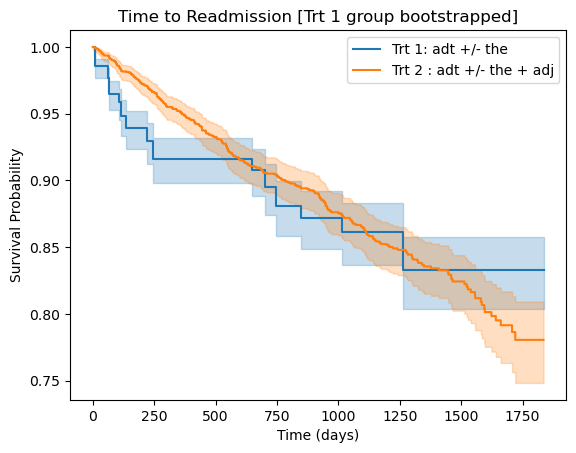

In [102]:
# Create a Kaplan-Meier plot
kmf = KaplanMeierFitter()
kmf.fit(trt1_bs["time_to_readmission"], event_observed=trt1_bs["readmission"], label='Trt 1: adt +/- the')
ax = kmf.plot()
kmf.fit(trt2["time_to_readmission"], event_observed=trt2["readmission"], label='Trt 2 : adt +/- the + adj')
kmf.plot(ax=ax)
plt.title('Time to Readmission [Trt 1 group bootstrapped]')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()

In [106]:
# Perform and print results of log-rank test
lrt = logrank_test(trt1_bs["time_to_readmission"], trt2["time_to_readmission"], trt1_bs["readmission"], trt2["readmission"], alpha=.99, weightings='peto')
lrt.print_summary()

<lifelines.StatisticalResult: Peto_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = Peto_test

---
 test_statistic    p  -log2(p)
           0.32 0.57      0.81

In [110]:
# Perform and print results of a survival difference at fixed point in time test
point_in_time = 365
kmf_trt1_bs = KaplanMeierFitter().fit(trt1_bs["time_to_readmission"], event_observed=trt1_bs["readmission"], label='Trt 1: adt +/- the')
kmf_trt2 = KaplanMeierFitter().fit(trt2["time_to_readmission"], event_observed=trt2["readmission"], label='Trt 2: adt +/- the + adj')
fpt = survival_difference_at_fixed_point_in_time_test(point_in_time, kmf_trt1_bs, kmf_trt2)
fpt.print_summary()

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 365
           fitterA = <lifelines.KaplanMeierFitter:"Trt 1: adt +/- the", fitted with 1130 total observations, 987 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Trt 2: adt +/- the + adj", fitted with 2348 total observations, 2059 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic      p  -log2(p)
          13.32 <0.005     11.89